In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
import glob
from PIL import Image

import torch
import torchvision
import torchvision.transforms as v2
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, Dataset, random_split, ConcatDataset, WeightedRandomSampler, SubsetRandomSampler,default_collate
from torchvision.datasets import ImageFolder
from torchvision import models
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.models import resnet34, ResNet34_Weights

from sklearn.model_selection import train_test_split
from tqdm import tqdm

torch.manual_seed(36)
torch.cuda.manual_seed(36)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(36)
random.seed(36)

device = torch.device("cuda")

In [2]:
if not os.path.exists('/home/jupyter/.kaggle/kaggle.json'):
    print("Please upload your kaggle.json file.")
else:
    if not os.path.exists('ucsc-cse-164-spring-2024-final-project.zip'):
        !kaggle competitions download -c ucsc-cse-164-spring-2024-final-project
    else:
        print("Zip file already exists.")
    
    if not os.path.exists('train_labeled.csv'):
        !unzip ucsc-cse-164-spring-2024-final-project.zip
    else:
        print("Dataset already extracted.")

Zip file already exists.
Dataset already extracted.


In [3]:
from torchvision.transforms.functional import resize

class CustomDataset(Dataset):
    def __init__(self, root, transform=None, isTrain=False, isLabeled=False, target_size=(224, 224)):
        self.root = root
        self.data = []
        self.transform = transform
        self.train = isTrain
        self.target_size = target_size

        if self.train:
            if isLabeled:
                labeled_df = pd.read_csv('train_labeled.csv')
                for _, row in labeled_df.iterrows():
                    img_path = os.path.join(root, 'labeled', f"{row['image']}")
                    label = int(row['id'])
                    self.data.append((img_path, label))
            else:
                for filename in os.listdir(root):
                    if filename.endswith('.jpg'):
                        img_path = os.path.join(root, filename)
                        self.data.append((img_path,None))  # No label for unlabeled data
        else:
            for filename in os.listdir(root):
                if filename.endswith('.jpg'):
                    img_path = os.path.join(root, filename)
                    self.data.append((img_path, None))  # No label for testing data

    def __getitem__(self, index):
        img_path, label = self.data[index]
        img = Image.open(img_path).convert('RGB')
        
        img = resize(img, self.target_size)
        
        if self.transform:
            img = self.transform(img)

        if self.train:
            return img, label
        else:
            return img, img_path

    def __len__(self):
        return len(self.data)
    

class CustomUnlabeledDataset(Dataset):
    def __init__(self, root, transform=None, target_size=(224, 224)):
        self.root = root
        self.data = []
        self.transform = transform
        self.target_size = target_size

        for filename in os.listdir(root):
            if filename.endswith('.jpg'):
                img_path = os.path.join(root, filename)
                self.data.append(img_path)  # No label for unlabeled data

    def __getitem__(self, index):
        img_path = self.data[index]
        img = Image.open(img_path).convert('RGB')
        
        img = resize(img, self.target_size)
        
        if self.transform:
            img = self.transform(img)
        return img
    
    def __len__(self):
        return len(self.data)



In [4]:
test_path = '/home/jupyter/test/'
train_path = '/home/jupyter/train/'
unlabeled_path = '/home/jupyter/train/unlabeled'

# Define transformations
transform = v2.Compose([
    v2.RandomRotation(degrees=15), 
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10),
    v2.Resize((256, 256), antialias=True),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform2 = v2.Compose([
    v2.Resize((256, 256), antialias=True),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train = CustomDataset(root=train_path, transform=transform, isTrain=True, isLabeled=True)
train2 = CustomDataset(root=train_path, transform=transform2, isTrain=True, isLabeled=True)
train_images = ConcatDataset([train, train2])
unlabeled_images = CustomUnlabeledDataset(root=unlabeled_path, transform=transform2)
testing_images = CustomDataset(root=test_path, transform=transform2, isTrain = False, isLabeled=False)

labeled_loader = DataLoader(train_images, batch_size=8, shuffle=True, num_workers=2)
unlabeled_loader = DataLoader(unlabeled_images, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(testing_images, batch_size=1, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


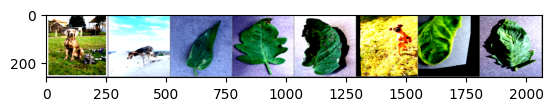

In [5]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(labeled_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [6]:

class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        self.resnet18 = models.resnet18(weights=None)
        
        num_fts = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_fts, num_classes)
        )
    
    def forward(self, x):
        x = self.resnet18(x)
        return x

model = ConvNet(num_classes=135)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
train_accuracy = []


def train_loop(model, labeled_loader, unlabeled_loader, criterion, optimizer):
    n_epochs = 25
    threshold = 0.7
    for epoch in range(n_epochs):
        loss_count = 0
        total_train = 0
        running_loss = 0.0
        correct_train = 0
        lam = 0.04
        model.train()
        
        for (labeled_images, labels) in labeled_loader:
            labeled_images, labels = labeled_images.to(device), labels.to(device)
            optimizer.zero_grad()

            labeled_outputs = model(labeled_images)
            labeled_loss = criterion(labeled_outputs, labels.squeeze())
            
            
            indices = random.sample(range(len(unlabeled_loader.dataset)), 8)

            unlabeled_images = [unlabeled_loader.dataset[idx] for idx in indices]

            unlabeled_images = images.to(device)

            unlabeled_outputs = model(unlabeled_images)

            unlabeled_probs = torch.softmax(unlabeled_outputs, dim=1)
            entropy = -torch.mean(torch.sum(unlabeled_probs * torch.log(unlabeled_probs + 1e-10), dim=1)) # entropy-based regularization

            loss = labeled_loss + lam * entropy
           
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted_train = torch.max(labeled_outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels.squeeze()).sum().item()
        
        lam = lam + 0.04
        epoch_loss = running_loss / len(labeled_loader)
        epoch_acc = correct_train / total_train
        train_accuracy.append(epoch_acc)

        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
            
            
            

        
# Evaluation
def test_loop(model, test_loader, criterion):
    model.eval()
    predict = {}
    predict["image"] = []
    predict["id"] = []

    with torch.no_grad():
        for i, (images, file_path) in enumerate(test_loader, 0):
            images = images.to(device)

            file_name = os.path.basename(file_path[0])

            output = model(images)
            _,predicted = torch.max(output,1)

            predict["image"].append(file_name)
            predict["id"].append(predicted.item())

        submission = pd.DataFrame(predict)
        submission.to_csv("submission.csv", index=False)
        
 

In [ ]:
train_loop(model, labeled_loader, unlabeled_loader, criterion, optimizer)

Epoch 1/25, Loss: 3.8850, Accuracy: 0.1564
Epoch 2/25, Loss: 3.2728, Accuracy: 0.2613
Epoch 3/25, Loss: 2.9830, Accuracy: 0.3188
Epoch 4/25, Loss: 2.7859, Accuracy: 0.3563
Epoch 5/25, Loss: 2.6298, Accuracy: 0.3874
Epoch 6/25, Loss: 2.4978, Accuracy: 0.4142
Epoch 7/25, Loss: 2.3867, Accuracy: 0.4388
Epoch 8/25, Loss: 2.2859, Accuracy: 0.4562
Epoch 9/25, Loss: 2.1845, Accuracy: 0.4749
Epoch 10/25, Loss: 2.1122, Accuracy: 0.4886
Epoch 11/25, Loss: 2.0181, Accuracy: 0.5065
Epoch 12/25, Loss: 1.9347, Accuracy: 0.5204
Epoch 13/25, Loss: 1.8594, Accuracy: 0.5385
Epoch 14/25, Loss: 1.7739, Accuracy: 0.5559
Epoch 15/25, Loss: 1.6999, Accuracy: 0.5674
Epoch 16/25, Loss: 1.6181, Accuracy: 0.5854
Epoch 17/25, Loss: 1.5420, Accuracy: 0.6021
Epoch 18/25, Loss: 1.4727, Accuracy: 0.6141
Epoch 19/25, Loss: 1.3942, Accuracy: 0.6345
Epoch 20/25, Loss: 1.3232, Accuracy: 0.6505
Epoch 21/25, Loss: 1.2498, Accuracy: 0.6684
Epoch 22/25, Loss: 1.1708, Accuracy: 0.6890
Epoch 23/25, Loss: 1.1073, Accuracy: 0.70

In [ ]:
test_loop(model, test_loader, criterion)

In [10]:
torch.save(model, 'model.pt')
torch.save(model.state_dict(), 'model_state.pth')